# Clustering Espectral

Esta técnica es un algoritmo de clustering que ha conseguido obtener un mejor rendimiento que otros algoritmos para el mismo cometido. La principal característica del **clustering espectral** es que trata cada punto de datos como si fuese un nodo en un grafo. Por tanto, el problema de clustering se transforma en un problema de [partición de grafos](https://en.wikipedia.org/wiki/Graph_partition).

La idea principal es construir un grafo con los puntos de datos de manera que haya una arista con peso entre dos puntos modelando la similaridad entre ellos.

## Características

Las principales ventajas del **clustering espectral** se pueden resumir en:

1. No es necesario asumir ninguna propiedad subyacente de los datos para que la técnica funcione, a diferencia de otros algoritmos que, por ejemplo, asumen distribuciones gaussianas de los valores. Por lo tanto esta técnica a priori es capaz de dar solución a problemas de clustering más genéricos.
2. Facilidad de implementación y velocidad: este algoritmo es bastante sencillo de implementar y, además, suele funcionar bastante rápido, pues consiste básicamente en operaciones matemáticas de álgebra lineal.


Sin embargo, tiene una **gran desventaja**, y es que el algoritmo es poco escalable, ya que basa su funcionamiento en el cálculo de autovalores y autovectores. De este modo, este algoritmo tiende a tardar mucho cuando el conjunto de datos de entrada es denso. De hecho, cuando mejor funciona es cuando la matriz de afinidad es dispersa.

Según recomiendan en la propia [documentación](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) de _sklearn_ del método:

> SpectralClustering requiere que se especifique el número de clusters. Funciona bien para un pequeño número de clusters pero no es aconsejable cuando se utilizan muchos clusters. Además, se recomienda un tamaño medio de conjunto de datos

## El algoritmo

Los pasos del clustering espectral son los siguientes:

1. **Construir el grafo de similitud**: En este paso se construye el grafo de similitud entre los puntos de entrada codificado como una matriz de adyacencia $A$. Dicha matriz puede construirse de distintas maneras:

    * **$\varepsilon$-vecindad**: para contruir este grafo hay que fijar inicialmente un umbral $\varepsilon$. De esa forma, todos los puntos que se encuentren en un radio $\varepsilon$ de similitud estarán conectados por una arista.
    ![ejemplo de epsilon-vecindad](https://i.imgur.com/6et5vqt.png)
    * **kNN**: Se fija un parámetro $k$ de antemano. Entonces, para cada par $u$ y $v$ de vértices se añade una arista dirigida $u\rightarrow v$ solo si $v$ está entre los $k$ vecinos más cercanos de $u$. Esto hace que el grafo sea dirigido y con las aristas ponderadas. Si queremos convertirlo en un grafo no dirigido podemos quitar la direccionalidad de las aristas o bien unir dos vértices solo si están recíprocamente conectados.
    ![ejemplo de vecindad kNN](https://i.imgur.com/2BSkklH.png)
    * **Grafo completamente conectado**: La tercera opción consiste en conectar todos y cada uno de los vértices para obtener un grafo completamente conectado, donde cada arista entre dos vértices tiene como peso la medida de similaridad entre dichos puntos.

2. **Proyectar los datos en un espacio dimensional inferior**: En este paso se reduce el espacio dimensional de los puntos de entrada para intentar que los que están relacionados queden más cerca en este espacio reducido. De esta forma se reduce la complejidad del problema de clustering y puede ser resuelto por algún algoritmo tradicional. Para ello se calcula la [Matriz Laplaciana del Grafo](https://es.wikipedia.org/wiki/Matriz_laplaciana), que se define como:

$$L=D-A$$

donde $A$ es la matriz de adyacencia anterior, mientras que $D$ es la matriz de grado del grafo, que se define como:

$$D_{ij}=\left\{\begin{matrix}
\sum_{j=1|(i,j)\in E}^n w_{ij}, i=j\\ 
0, i \neq j
\end{matrix}\right.$$

3. **Hacer clustering con los datos proyectados**: En este paso se aplica un algoritmo tradicional de clustering sobre los datos proyectados en un espacio dimensional inferior. De esta forma se termina asignando un grupo (cluster) a cada punto de entrada.


## Caso de estudio

Vamos a aplicar **Clustering Espectral** a un problema de aprendizaje supervisado, pero tratándolo como si no tuviésemos información sobre el _ground truth_.

El conjunto de datos que se va a utilizar es [credit-g](https://www.openml.org/d/31), del repositorio OpenML. Este conjunto de datos está formado por 20 características relacionadas con los préstamos solicitados por los clientes de un banco alemán. El problema radica en clasificar dichos préstamos según su riesgo crediticio:

* Riesgo alto
* Riesgo bajo

Hay varias variables del conjunto de datos que son nominales:

- checking_status
- credit_history
- purpose
- savings_status
- employment
- personal_status
- other_parties
- property_magnitude
- other_payment_plans
- housing
- job
- own_telephone
- foreign_worker

In [0]:
# Librerías necesarias

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [0]:
raw_credito = fetch_openml(data_id=31)
credito = pd.DataFrame(data=raw_credito.data, columns=raw_credito.feature_names)

In [40]:
credito.head(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0.0,6.0,4.0,3.0,1169.0,4.0,4.0,4.0,2.0,0.0,4.0,0.0,67.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0
1,1.0,48.0,2.0,3.0,5951.0,0.0,2.0,2.0,1.0,0.0,2.0,0.0,22.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0
2,3.0,12.0,4.0,6.0,2096.0,0.0,3.0,2.0,2.0,0.0,3.0,0.0,49.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0


In [0]:
# Un poco de pre-procesado para las columnas nominales. Se usará one-hot-encoder
numeric_features = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
nominal_features = list(set(raw_credito.feature_names) - set(numeric_features))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(categories='auto'), nominal_features)])

credito = preprocessor.fit_transform(credito)

Vamos a utilizar el análisis de componentes principales (PCA) para proyectar el conjunto de datos sobre dos características, de forma que podamos dibujarlo.

In [42]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(credito) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']
X_principal.head(5)

,P1,P2
0,-0.162443,3.375510
1,0.940066,-2.766547
2,-0.297623,1.546554
3,2.634923,0.053242
4,1.621129,2.243514


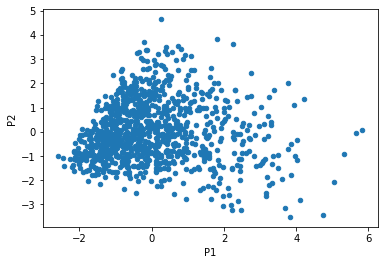

In [43]:
X_principal.plot.scatter(x='P1', y='P2')

Ahora vamos a lanzar el algoritmo de **clustering espectral** para ver cómo se agrupa cada uno de los préstamos solicitados. Fijamos la medida de afinidad a `laplacian` para que utilice la matriz Laplaciana como hemos visto en la descripción del algoritmo. 

In [0]:
spectral = SpectralClustering(n_clusters=2, random_state=1337, affinity='laplacian')
labels = spectral.fit_predict(credito)

Ahora mostramos en una figura el grupo asignado por el algoritmo a cada muestra con un color distinto.

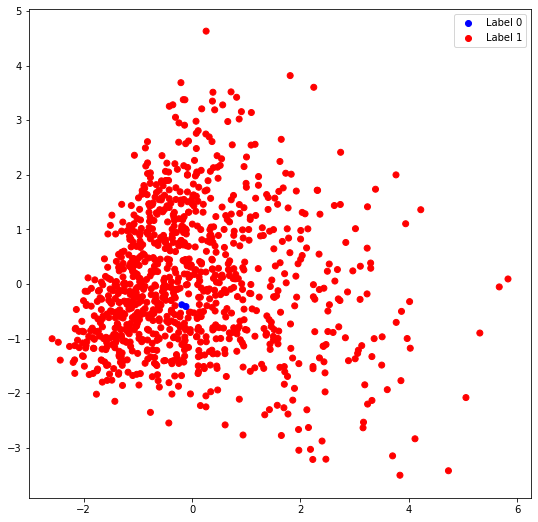

In [46]:
# Creamos un vector con el color asignado a cada etiqueta
cvec = ['r' if label==0 else 'b' for label in labels] 
  
# Plotting the clustered scatter plot 
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
plt.legend((b, r), ('Label 0', 'Label 1')) 
plt.show() 

Vamos a evaluar el rendimiento del modelo con alguna de las métricas que ya hemos visto, así como usando el _ground-truth_.

In [50]:
print('Silhouette: ', silhouette_score(credito, labels))
print('Rand Index (con ground truth): ', adjusted_rand_score(raw_credito.target, labels))

Silhouette:  -0.020481333339523313
Adjusted Rand (con ground truth):  -0.002274265836774881


## Ejercicio:

Prueba y compara los resultados del **clustering espectral** con respecto a la función utilizada para calcular la similaridad entre puntos. Puedes consultar las distintas funciones en la [documentación](https://scikit-learn.org/stable/modules/metrics.html#metrics).

---

Creado por **Raúl Lara** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">